In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import gc
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
df = pd.read_csv('sample_data/final_df_sleep_v1.csv')
df

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,time,target
0,-494,-759,4060,0,0,1,2023-05-12 00:20:30.041084,0
1,-492,-766,4061,-5,1,-1,2023-05-12 00:20:30.057801,0
2,-489,-765,4063,2,2,2,2023-05-12 00:20:30.175278,0
3,-492,-766,4058,1,3,1,2023-05-12 00:20:30.266675,0
4,-499,-766,4060,-1,2,0,2023-05-12 00:20:30.355109,0
...,...,...,...,...,...,...,...,...
1747640,2095,123,3583,11,-7,-1,2023-05-26 07:46:44.039838,0
1747641,2101,136,3586,6,-9,0,2023-05-26 07:46:44.130824,0
1747642,2098,145,3577,9,-9,-2,2023-05-26 07:46:44.221912,0
1747643,2101,131,3574,8,-10,-2,2023-05-26 07:46:44.265720,0


In [ ]:
df.describe()

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,target
count,1.747645e+06,1.747645e+06,1.747645e+06,1.747645e+06,1.747645e+06,1.747645e+06,1.747645e+06
mean,1.042456e+03,1.252175e+02,1.494959e+03,5.305313e+00,-6.983584e+00,-1.155455e+00,2.043951e-01
std,1.333304e+03,2.331283e+03,2.546211e+03,1.107924e+02,6.730020e+01,8.790350e+01,4.032590e-01
min,-8.188000e+03,-1.411400e+04,-7.509000e+03,-9.380000e+03,-4.681000e+03,-5.269000e+03,0.000000e+00
25%,-2.900000e+01,-1.581000e+03,6.880000e+02,2.000000e+00,-1.000000e+01,-2.000000e+00,0.000000e+00
50%,1.191000e+03,3.300000e+02,2.282000e+03,6.000000e+00,-8.000000e+00,-1.000000e+00,0.000000e+00
75%,2.157000e+03,2.121000e+03,3.414000e+03,9.000000e+00,-4.000000e+00,0.000000e+00,0.000000e+00
max,1.007900e+04,9.052000e+03,1.098700e+04,9.310000e+03,4.887000e+03,5.716000e+03,1.000000e+00


<Axes: xlabel='target', ylabel='Count'>

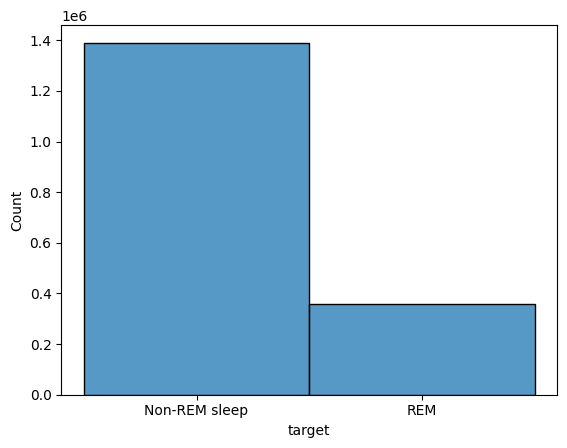

In [ ]:
stat_df = deepcopy(df)
stat_df['target'] = stat_df['target'].replace([0, 1], ['Non-REM sleep', 'REM'])

sns.histplot(stat_df['target'])

In [ ]:
df = df.drop(columns = ['time'])
df

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,target
0,-494,-759,4060,0,0,1,0
1,-492,-766,4061,-5,1,-1,0
2,-489,-765,4063,2,2,2,0
3,-492,-766,4058,1,3,1,0
4,-499,-766,4060,-1,2,0,0
...,...,...,...,...,...,...,...
1747640,2095,123,3583,11,-7,-1,0
1747641,2101,136,3586,6,-9,0,0
1747642,2098,145,3577,9,-9,-2,0
1747643,2101,131,3574,8,-10,-2,0


In [ ]:
names = df.columns
scaler = MinMaxScaler()

sc = scaler.fit_transform(df.iloc[:, :-1])
scaled_df = pd.DataFrame(sc, columns = names[:-1])
scaled_df['target'] = df['target']
scaled_df

,index,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,target
0,0.073242,0.475359,0.549726,0.861696,0.548249,0.497339,0.509195,0
1,0.281369,0.631277,0.682931,0.712126,0.548659,0.495622,0.509062,0
2,0.269449,0.643306,0.595331,0.794841,0.547782,0.496137,0.509595,0
3,0.281088,0.459061,0.501233,0.255411,0.548834,0.495451,0.509195,0
4,0.478633,0.572759,0.378317,0.802031,0.548366,0.496309,0.509195,0
...,...,...,...,...,...,...,...,...
174759,0.359596,0.717113,0.591721,0.724578,0.548600,0.496652,0.509062,0
174760,0.894435,0.622429,0.477348,0.826564,0.548659,0.496137,0.509195,1
174761,0.821546,0.544354,0.747308,0.593611,0.549535,0.495794,0.508795,0
174762,0.263154,0.675281,0.693039,0.614068,0.548366,0.496652,0.508929,1


In [ ]:
def prepare_df(df, n_steps = 1):
  df = deepcopy(df)

  for i in range(1, n_steps + 1):
    df[f'acceleration_x(t-{i})'] = df['acceleration_x'].shift(i)
    df[f'acceleration_y(t-{i})'] = df['acceleration_y'].shift(i)
    df[f'acceleration_z(t-{i})'] = df['acceleration_z'].shift(i)
    df[f'gyro_x(t-{i})'] = df['gyro_x'].shift(i)
    df[f'gyro_y(t-{i})'] = df['gyro_y'].shift(i)
    df[f'gyro_z(t-{i})'] = df['gyro_z'].shift(i)

  df.dropna(inplace = True)
  df = df.reset_index(drop = True)

  return df

In [ ]:
shifted_df = prepare_df(scaled_df, 38)
shifted_df

,index,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,target,acceleration_x(t-1),acceleration_y(t-1),...,acceleration_z(t-37),gyro_x(t-37),gyro_y(t-37),gyro_z(t-37),acceleration_x(t-38),acceleration_y(t-38),acceleration_z(t-38),gyro_x(t-38),gyro_y(t-38),gyro_z(t-38)
0,0.369115,0.642996,0.396186,0.777201,0.548425,0.496481,0.509462,1,0.515406,0.286806,...,0.712126,0.548659,0.495622,0.509062,0.475359,0.549726,0.861696,0.548249,0.497339,0.509195
1,0.056819,0.564920,0.276818,0.614068,0.548249,0.498026,0.509462,0,0.642996,0.396186,...,0.794841,0.547782,0.496137,0.509595,0.631277,0.682931,0.712126,0.548659,0.495622,0.509062
2,0.067250,0.564920,0.276217,0.612733,0.548308,0.498026,0.509462,0,0.564920,0.276818,...,0.255411,0.548834,0.495451,0.509195,0.643306,0.595331,0.794841,0.547782,0.496137,0.509595
3,0.211685,0.589135,0.563684,0.835310,0.548717,0.496137,0.509195,0,0.564920,0.276217,...,0.802031,0.548366,0.496309,0.509195,0.459061,0.501233,0.255411,0.548834,0.495451,0.509195
4,0.673750,0.487776,0.435894,0.850726,0.548483,0.496824,0.509195,0,0.589135,0.563684,...,0.835458,0.548483,0.495794,0.509195,0.572759,0.378317,0.802031,0.548366,0.496309,0.509195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174721,0.359596,0.717113,0.591721,0.724578,0.548600,0.496652,0.509062,0,0.620799,0.720414,...,0.261488,0.548659,0.496481,0.509062,0.693597,0.587690,0.756226,0.548600,0.496137,0.509062
174722,0.894435,0.622429,0.477348,0.826564,0.548659,0.496137,0.509195,1,0.717113,0.591721,...,0.631782,0.548717,0.496309,0.509462,0.420489,0.539619,0.261488,0.548659,0.496481,0.509062
174723,0.821546,0.544354,0.747308,0.593611,0.549535,0.495794,0.508795,0,0.622429,0.477348,...,0.780388,0.548191,0.496137,0.509195,0.367792,0.280669,0.631782,0.548717,0.496309,0.509462
174724,0.263154,0.675281,0.693039,0.614068,0.548366,0.496652,0.508929,1,0.544354,0.747308,...,0.701304,0.548717,0.496137,0.508929,0.647187,0.612899,0.780388,0.548191,0.496137,0.509195


In [ ]:
X = shifted_df.drop(columns = ['target'])
y = shifted_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3,
                                                    shuffle = True)

In [ ]:
del shifted_df
del df
gc.collect()

393

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return self.len

In [ ]:
BATCH_SIZE = 256
INPUT_DIM = 234
CONV_DIM = 3648 
HIDDEN_LAYERS = 1024
OUTPUT_DIM = 2
NUM_STACKED_LAYERS = 1

In [ ]:
train_data = Data(X_train.to_numpy(), y_train.to_numpy())
test_data = Data(X_test.to_numpy(), y_test.to_numpy())

train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [ ]:
class CNN_LSTM(nn.Module):
  def __init__(self):
    super(CNN_LSTM, self).__init__()

    self.conv = nn.Sequential(nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3),
                              nn.BatchNorm1d(num_features = 16),
                              nn.ELU(),
                              nn.MaxPool1d(kernel_size = 2),
                              #nn.Dropout(0.2),
                              nn.Conv1d(in_channels = 16, out_channels = 64, kernel_size = 3),
                              nn.BatchNorm1d(num_features = 64),
                              nn.ELU(),
                              nn.MaxPool1d(kernel_size = 2),
                              #nn.Dropout(0.2),
                              nn.Flatten())  
    
    self.lstm = nn.Sequential(nn.LSTM(input_size = CONV_DIM, hidden_size  = HIDDEN_LAYERS, num_layers = NUM_STACKED_LAYERS, batch_first = True))  


    self.linear = nn.Sequential(nn.Linear(HIDDEN_LAYERS, HIDDEN_LAYERS // 4),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(HIDDEN_LAYERS // 4, OUTPUT_DIM))
    
  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.conv(x)
    x = x.unsqueeze(1)
    x, _ = self.lstm(x)
    x = self.linear(x[:, -1, :])
    return x


In [ ]:
model = CNN_LSTM().to(device)

In [ ]:
print(model)

CNN_LSTM(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): Sequential(
    (0): LSTM(3648, 1024, batch_first=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
  loop = tqdm(train_loader)
  for batch, (X, y) in enumerate(loop):
    X, y = X.to(device), y.to(device)

    output = model(X)

    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
    loop.set_postfix(loss = loss.item())

Epoch [2/3]: 100%|██████████| 1912/1912 [15:09<00:00,  2.10it/s, loss=0.658]


In [ ]:
correct, total = 0, 0
list_pred, list_true = [], []

with torch.no_grad():
  for (X, y) in test_loader:
    X, y = X.to(device), y.to(device)

    output = model(X)
    pred = output.argmax(dim = 1, keepdim = True)
    list_pred.append(pred.cpu().numpy())
    list_true.append(y.cpu().numpy())
    correct += pred.eq(y.view_as(pred)).sum().item()
accuracy = correct / len(test_loader.dataset)
print(f'Accuracy: {accuracy:>0.4f} %')

Accuracy: 0.8229 %


In [ ]:
list_pred = np.concatenate(list_pred)
list_pred = np.hstack(list_pred).tolist()
list_true = np.concatenate(list_true)
list_true = np.hstack(list_true).tolist()
cm = confusion_matrix(list_pred, list_true)
cm

In [ ]:
nn_AS_test = accuracy_score(list_pred, list_true)
nn_BAS_test = balanced_accuracy_score(list_pred, list_true)
nn_f1_weighted_test = f1_score(list_pred, list_true, average = 'weighted')
catboost_roc_auc_score_test = roc_auc_score(list_pred, list_true)
nn_mcc_test = matthews_corrcoef(list_pred, list_true)

nn_test_scores_dict = {'Accuracy' : nn_AS_test,
                       'Balanced accuracy' : nn_BAS_test,
                       'F1 score' : nn_f1_weighted_test,
                       'ROC auc score' : catboost_roc_auc_score_test,
                       'Matthews correlation coefficient' : nn_mcc_test}

nn_test_scores_df = pd.DataFrame.from_dict(nn_test_scores_dict, orient = 'index', columns = ['Scores'])

nn_test_scores_df

,Scores
Accuracy,0.822885
Balanced accuracy,0.733621
F1 score,0.843444
ROC auc score,0.733621
Matthews correlation coefficient,0.367433


In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-REM sleep', 'REM sleep'])
disp.plot()
plt.show()

In [ ]:
model.eval()

CNN_LSTM(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): Sequential(
    (0): LSTM(3648, 1024, batch_first=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
example, _ = next(iter(train_loader))
model(example.to(device))

tensor([[ 0.3732, -0.2769],
        [ 0.5438, -0.3618],
        [ 1.8067, -1.9869],
        [ 0.2322, -0.0111],
        [ 0.9511, -0.7121],
        [-1.2445,  1.6812],
        [ 1.9023, -2.1241],
        [ 1.3548, -1.3306],
        [ 0.6450, -0.4762],
        [-1.2308,  1.6206],
        [ 0.5161, -0.3945],
        [ 0.8061, -0.7966],
        [-0.9868,  1.2929],
        [ 1.0604, -1.0703],
        [-0.1538,  0.4716],
        [ 1.7425, -2.1338],
        [ 1.7551, -1.8933],
        [ 0.3459, -0.1173],
        [ 2.0482, -2.2858],
        [ 1.3609, -1.4346],
        [ 0.5560, -0.4577],
        [ 0.1920,  0.0579],
        [ 0.3453, -0.1987],
        [ 0.8868, -0.8347],
        [ 1.9866, -2.3416],
        [ 0.5745, -0.4799],
        [ 0.3651, -0.1807],
        [ 2.1278, -2.5816],
        [ 1.3211, -1.3365],
        [ 0.8242, -0.5957],
        [ 0.5734, -0.4496],
        [ 1.8243, -2.0948],
        [-0.3373,  0.6131],
        [ 1.5109, -1.6103],
        [ 1.2241, -1.1972],
        [ 0.4574, -0

In [ ]:
traced_script_module = torch.jit.trace(model, example.to(device))

In [ ]:
traced_script_module_optimized = optimize_for_mobile(traced_script_module)

In [ ]:
traced_script_module_optimized._save_for_lite_interpreter('./sleep_lstm_3sec_6params.ptl')